# Sheet 2

Julian Kusch & Tim Weinreich

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde

## 1 Kernel Density Estimation
(a)

In [54]:
def biweight(x, mu, w):
    """biweight kernel at mean mu, with bandwidth w evaluated at x"""
    #TODO: implement the quartic (biweight) kernel

    if mu - w <= x <= mu + w:
        return 15/(16*w) * (1 - ((x - mu) / w)**2)**2
    else:
        return 0

Text(0.5, 1.0, 'Quartic kernel function')

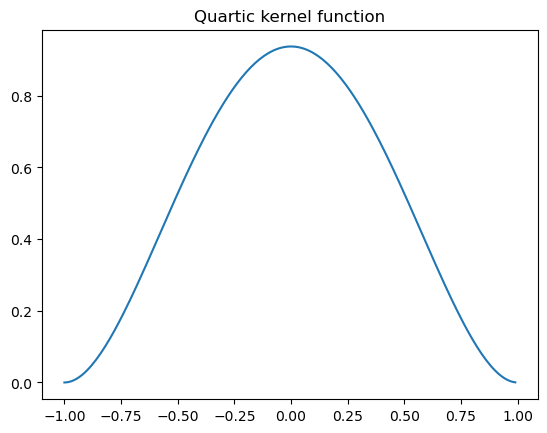

In [55]:
# TODO plot the kernel

x_list = np.arange(-1, 1, 0.01)
mu = 0
w = 1

biweights = []
for x in x_list:
    biweights.append(biweight(x, mu, w))
plt.plot(x_list, biweights)
plt.title("Quartic kernel function")

(b)

In [56]:
# load the data
data = np.load("data/samples.npy")
data50 = data[:50]
print(f'{data.shape=}, {data50.shape=}')

data.shape=(10000,), data50.shape=(50,)


In [60]:
def kde(x_list, obs, w):
    # TODO: implement the KDE with the biweight kernel
    n = len(obs)
    kde_list = []
    for x in x_list:
        biweights = []
        for o in obs:
            biweights.append(biweight(x, o, w))
        kde_list.append(1 / n * np.sum(biweights))
    return np.array(kde_list)

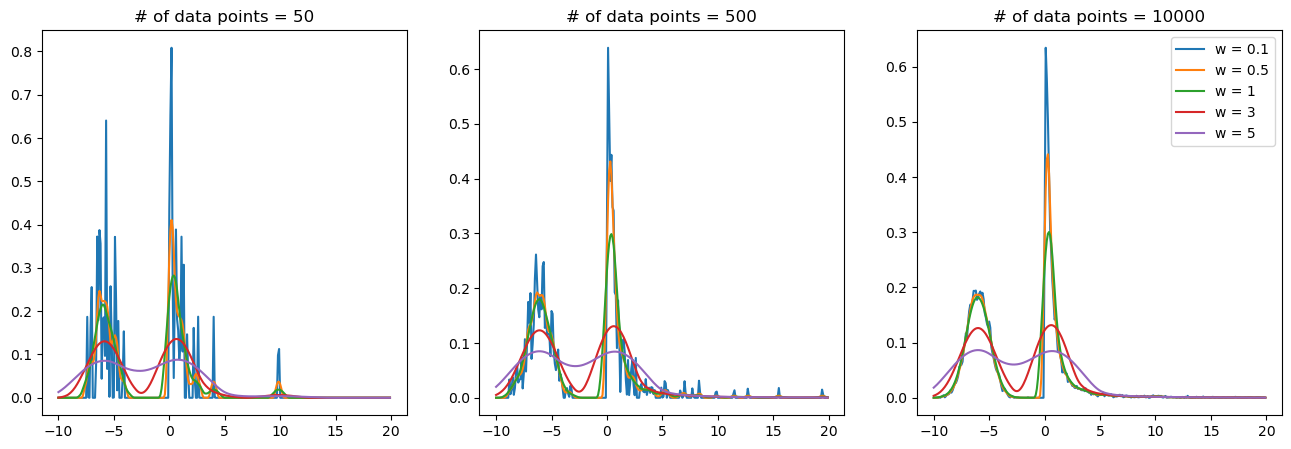

In [70]:
# TODO: compute and plot the kde on the first 50 data points

x = np.arange(-10, 20, 0.1)
w_list = [0.1, 0.5, 1, 3, 5]

num_data = [50, 500, 10000]
 
fig, axs = plt.subplots(1,3, figsize=(16,5))
for i, ax in enumerate(axs):
    for w in w_list:
        ax.plot(x, kde(x, data[:num_data[i]], w), label=f"w = {w}")
        ax.set_title(f"# of data points = {num_data[i]}")
plt.legend()

# TODO: explore what happens when you increase the number of points

- The smaller the bandwidth, the more features of the underlying distribution are captured
- If the bandwidth is too small, the data is overfitted and outliers have a huge impact
- In our opinion w = 1 is the best tradeoff here

## 3 Mean-Shift
#### (a)

The update step for $x_{t+1}^{(j)}$ in gradient ascent on the KDE with the Epanechnikov kernel is:

$$
x_{t+1}^{(j)} = x_t^{(j)} + \alpha_t^{(j)} \frac{2}{n} \sum_{i : \| x_i - x_t^{(j)} \| < 1} (x_i - x_t^{(j)})
$$

We want to make this update step equivalent to moving toward the local mean $m_t^{(j)}$ of points within the kernel window:

$$
x_{t+1}^{(j)} = m_t^{(j)} = \frac{\sum_{i : \| x_i - x_t^{(j)} \| < 1} x_i}{\sum_{i : \| x_i - x_t^{(j)} \| < 1} 1}
$$

To make our gradient ascent update step match the shift required to reach the local mean $m_t^{(j)}$, we rewrite the update equation as:

$$
\alpha_t^{(j)} \frac{2}{n} \sum_{i : \| x_i - x_t^{(j)} \| < 1} (x_i - x_t^{(j)}) = \frac{\sum_{i : \| x_i - x_t^{(j)} \| < 1} x_i}{\sum_{i : \| x_i - x_t^{(j)} \| < 1} 1} - x_t^{(j)} = \frac{\sum_{i : \| x_i - x_t^{(j)} \| < 1} (x_i - x_t^{(j)})}{\left( \sum_{i : \| x_i - x_t^{(j)} \| < 1} 1 \right)^{2}}
$$

Now, we can see that to satisfy this equality, $\alpha_t^{(j)}$ should be chosen as:

$$
\alpha_t^{(j)} = \frac{n}{2 \cdot \sum_{i : \| x_i - x_t^{(j)} \| < 1} (x_i - x_t^{(j)})} \cdot \frac{\sum_{i : \| x_i - x_t^{(j)} \| < 1} (x_i - x_t^{(j)})}{\left( \sum_{i : \| x_i - x_t^{(j)} \| < 1} 1 \right)^{2}} = \frac{n}{2 \cdot \left( \sum_{i : \| x_i - x_t^{(j)} \| < 1} 1 \right)^{2}}
$$

The demnominator, $\left( \sum_{i : \| x_i - x_t^{(j)} \| < 1} 1 \right)^{2}$, represents the count of neighboring points, balancing the influence of neighbors, making this a sensible choice for moving toward the local mean effectively.




#### (b)

In [24]:
# TODO: implement the update to the local mean

def mean_shift_step(x, xt, r=1):
    """
    A single step of mean shift, moving every point in xt to the local mean of points in x within a radious of r.
    
    Parameters
    ----------
    x : np.ndarray
        Array of points underlying the KDE, shape (d, N1)
    xt : np.ndarray
        Current state of the mean shift algorithm, shape (d, N2)
    n_components : int, optional
        Number of requested components. By default returns all components.
        
    Returns
    -------
    np.ndarray
        the points after the mean-shift step
    """
    # NOTE: For the excercise you only need to implement this for d == 1. 
    #       If you want some extra numpy-practice, implement it for arbitrary dimension     god please no!!!
    
    assert xt.shape[0] == x.shape[0], f'Shape mismatch: {x.shape[0]}!={xt.shape[0]}'
    
    # TODO: start by computing a N by N matrix 'dist' of distances, 
    #       such that dists[i, j] is the distance between x[i] and xt[j]

    N = len(x)
    dists = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            dists[i,j] = np.abs(x[i] - xt[j])

    xt_update = []
    for j in range(N):   
        alpha = N / (np.max([len([dists[i,j] for i in range(N) if np.abs(dists[i,j]) < r]), 1])**2  * 2)
        xt_update.append(xt[j] + alpha * (2/N) * np.sum([dists[i,j] for i in range(N) if np.abs(dists[i,j]) < r]))
    
    local_means = np.array(xt_update)
    return local_means
    

Text(0, 0.5, 'x(t)')

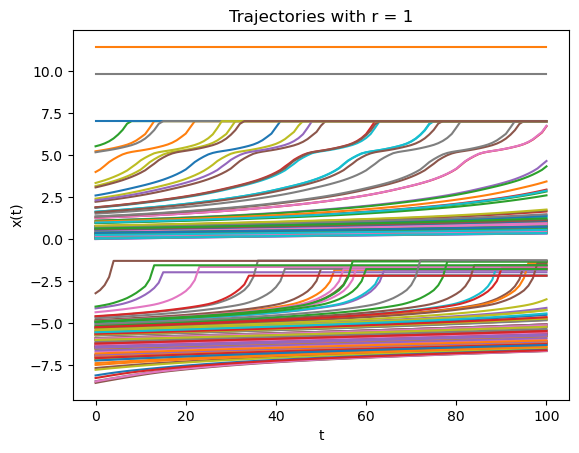

In [21]:
# load the data
data = np.load("data/samples.npy")
x = data[:200]  # use e.g. the first 200 points
xt = x

trajectories = [xt]
max_steps = 100
for step in range(max_steps):
    
    # TODO: update xt with your mean shift step

    xt = mean_shift_step(x, xt, r=1)
    
    trajectories.append(xt)
    if np.allclose(trajectories[-1], trajectories[-2]):  # break in case of convergence
        break
trajectories = np.stack(trajectories)
n_steps = len(trajectories) - 1

# TODO: plot the trajectories

t = np.arange(0, n_steps)

for i in range(len(x)):
    plt.plot(trajectories.T[i])
plt.title("Trajectories with r = 1")
plt.xlabel("t")
plt.ylabel("x(t)")

Text(0, 0.5, 'x(t)')

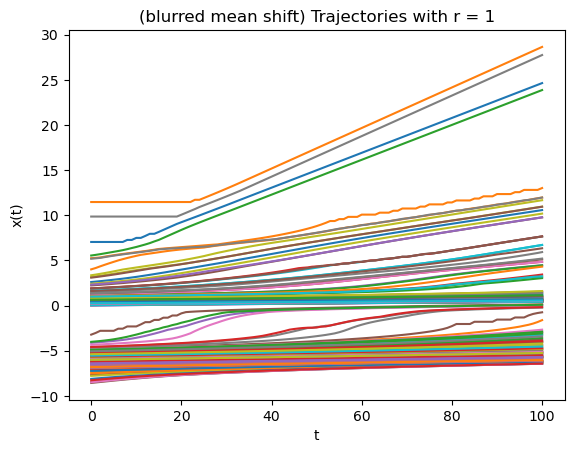

In [23]:
# TODO: repeat the above for "blurring" mean shift

# load the data
data = np.load("data/samples.npy")
x = data[:200]  # use e.g. the first 200 points
xt = x

trajectories = [xt]
max_steps = 100
for step in range(max_steps):
    
    # TODO: update xt with your mean shift step

    xt = mean_shift_step(xt, xt, r=1)
    
    trajectories.append(xt)
    if np.allclose(trajectories[-1], trajectories[-2]):  # break in case of convergence
        break
trajectories = np.stack(trajectories)
n_steps = len(trajectories) - 1

# TODO: plot the trajectories

t = np.arange(0, n_steps)

for i in range(len(x)):
    plt.plot(trajectories.T[i])
plt.title("(blurred mean shift) Trajectories with r = 1")
plt.xlabel("t")
plt.ylabel("x(t)")

The clusters seem to stay the same between the two methods (gaussians, poissons, outliers) but for the blurred method, the trajectories diverge as they are not coupled to the original positions of the input data.